## Masking and Patching

In [196]:
import jax
from jax import lax
from jax import numpy as jnp
import numpy as np
import einops
import equinox as eqx
import optax

import matplotlib.pyplot as plt

from jepax.data import build_dataset
dataloader, _, _, _ = build_dataset("CIFAR10", data_dir="~/data")

x, y = next(iter(dataloader))

/Users/anton/source/jepax/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [197]:
x.shape

(32, 32, 32, 3)

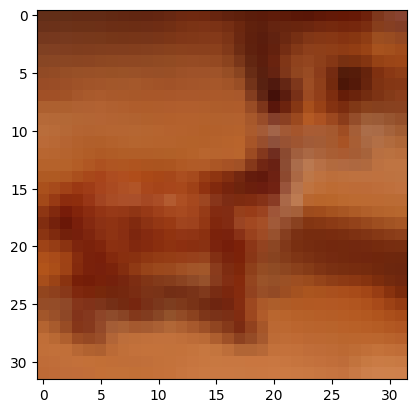

In [199]:
plt.imshow(x[0])

## 1. Patchifier + masking

In [200]:
def patchify(x, patch_size=2):
    return einops.rearrange(
        x,
        "(h ph) (w pw) c -> (h w) (c ph pw)",
        ph=patch_size,
        pw=patch_size,
    )

def unpatchify(x, patch_size=2, n_patch=16):
    return einops.rearrange(
        x,
        "(h w) (c ph pw) -> (h ph) (w pw) c",
        h=n_patch,
        ph=patch_size,
        pw=patch_size,
    )

x_patch = patchify(x[0])
x_patch.shape

(256, 12)

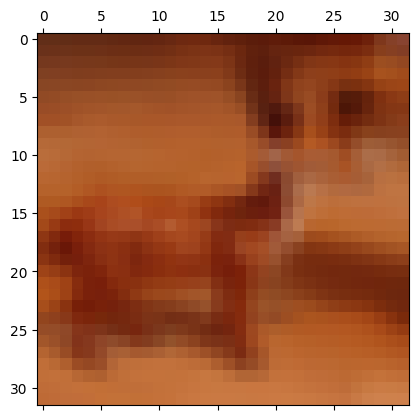

In [ ]:
plt.matshow(unpatchify(x_patch))

13 14
2 3


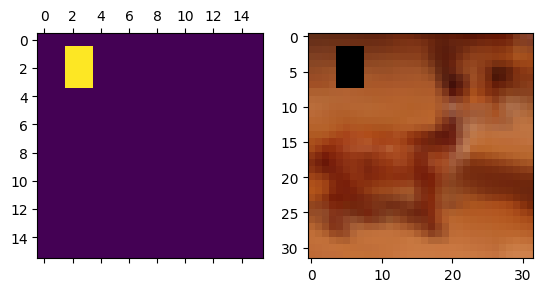

In [ ]:
import math

def create_mask(key, h=32, w=32, patch_size=2, scale=0.15, aspect=1.0):
    """
    Creates an IJEPA mask. 
    Returns patch indices

    TODO: optimize rng, make vmapple, make class instance attributes
    """
    key, k1, k2 = jax.random.split(key, 3)


    h_patch = h // patch_size
    w_patch = w // patch_size

    # (i, j) indices for top left corner
    i_max = math.ceil((1 - scale) * w // 2) 
    j_max = math.ceil((1 - scale / aspect) * h // 2) 

    pw_mask = int(w * scale // patch_size)
    ph_mask = int(w * scale * aspect // patch_size)

    assert pw_mask > 0 and ph_mask > 0, "scale or aspect ratio creates empty mask"

    mask = jnp.zeros((h_patch, w_patch)).astype(bool)

    print(i_max, j_max)
    print(pw_mask, ph_mask)

    i = jax.random.randint(k1, (), minval=0, maxval=i_max)
    j = jax.random.randint(k2, (), minval=0, maxval=j_max)

    #i, j = i_max, j_max
    # mask = mask.at[i:i+ph_mask, j:j+pw_mask].set(True)

    patch = jnp.ones((ph_mask, pw_mask), dtype=mask.dtype)
    mask = lax.dynamic_update_slice(mask, patch, (i, j))

    return mask

def visualize_mask(x, mask):
    mask = ~mask.flatten()
    x_masked = jax.vmap(lambda x, m: x * m)(patchify(x), mask)
    x_masked_img = unpatchify(x_masked)
    return x_masked_img


key = jax.random.PRNGKey(3)

# prediction type mask for IJEPA
mask_pred = create_mask(key, aspect=1.5)

fig, ax = plt.subplots(1,2)
ax[0].matshow(mask_pred)
ax[1].imshow(visualize_mask(x[0], mask_pred))

3 3
12 12


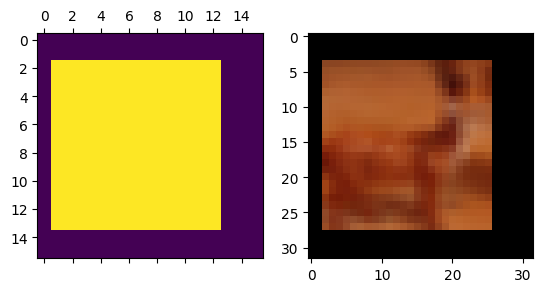

In [203]:
key = jax.random.PRNGKey(42)
mask_ctx = create_mask(key, scale=0.8, aspect=1.0)

fig, ax = plt.subplots(1,2)
ax[0].matshow(mask_ctx)
ax[1].imshow(visualize_mask(x[0], ~mask_ctx))

13 14
2 3


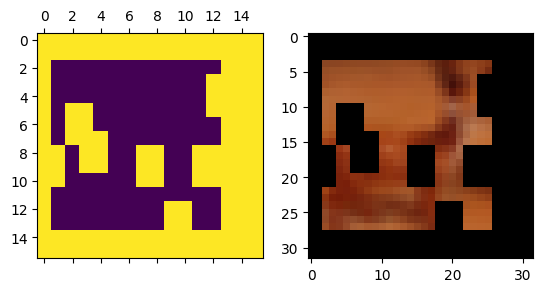

In [204]:
from functools import partial

keys = jax.random.split(key, 7)
masks_pred = jax.vmap(partial(create_mask, scale=0.15, aspect=1.5))(keys)
mask_pred = jnp.any(masks_pred, axis=0)

mask_total = ~mask_ctx | mask_pred

fig, ax = plt.subplots(1,2)
ax[0].matshow(mask_total)
ax[1].imshow(visualize_mask(x[3], mask_total))